In [4]:
%%capture
!pip3 install nltk
!pip3 install nltk
!pip3 install plotly
!pip3 install gensim
!pip3 install python-Levenshtein

In [250]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
import pandas as pd
import html
from wordcloud import WordCloud
import nltk
import re
from IPython.display import Markdown, display
from gensim import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import numpy
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from nltk.tokenize import RegexpTokenizer


csv_file = open('sms_collection.csv', 'r')
lines = csv_file.readlines()

VALID_LABELS = ["spam", "ham"]

dataframe_cols = ["IsSpam", "MessageText"]
sms_data = pd.DataFrame(columns = dataframe_cols)

is_header = True
for line in lines:
    # skip the first line
    if is_header:
        is_header = False
        continue

    parts = line.split(";")
    label = parts[0]
    
    if label not in VALID_LABELS:
        label = 'ham'

    sms_text = html.unescape(";".join(parts[1:]))
    sms_text.rstrip()
    sms_text.lstrip()

    is_spam = int(label == "spam")

    row = pd.DataFrame([[is_spam, sms_text]], columns = ["IsSpam", "MessageText"])
    sms_data = sms_data.append(row)

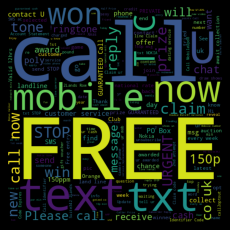

In [252]:
spam_contents = " ".join(list(sms_data.loc[sms_data['IsSpam'] == 1]['MessageText']))
spam_wordcloud = WordCloud(width = 512, height = 512).generate(spam_contents)
plt.figure(figsize = (3, 3), facecolor = "k")
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

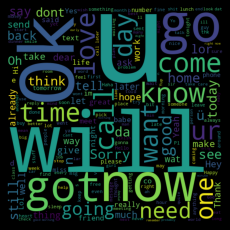

In [253]:
ham_contents = " ".join(list(sms_data.loc[sms_data['IsSpam'] == 0]['MessageText']))
ham_wordcloud = WordCloud(width = 512, height = 512).generate(ham_contents)
plt.figure(figsize = (3, 3), facecolor = "k")
plt.imshow(ham_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [254]:
total_observations = len(sms_data.index)
print("Dataset Size: {}".format(total_observations))
print(sms_data['IsSpam'].value_counts())
print(sms_data['IsSpam'].value_counts() / len(sms_data.index) * 100.0)

Dataset Size: 5574
0    4827
1     747
Name: IsSpam, dtype: int64
0    86.598493
1    13.401507
Name: IsSpam, dtype: float64


In [255]:
def pre_process(message):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()
    punctuations = string.punctuation

    message = message.rstrip()
    message = message.lstrip()
    tokens = tokenizer.tokenize(message)    
    tokens = [word.lower() for word in tokens]
    
    # lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # remove stop words
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations]
    # stemming
    tokens = [porter_stemmer.stem(word) for word in tokens]
    
    return tokens

In [257]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    sms_data,
    sms_data['IsSpam'],
    test_size = 0.33
)

X_train_tagged = X_train.apply(lambda sms: TaggedDocument(words=pre_process(sms['MessageText']), tags=[sms.IsSpam]), axis=1)
X_test_tagged = X_test.apply(lambda sms: TaggedDocument(words=pre_process(sms['MessageText']), tags=[sms.IsSpam]), axis=1)

In [258]:
# build a doc2vec model with the tagged values from the training set
doc2vec_model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
doc2vec_model.build_vocab([x for x in X_train_tagged.values])

epoch_count = 50
for epoch in range(50):
    doc2vec_model.train(sklearn.utils.shuffle([x for x in X_train_tagged.values]), total_examples=len(X_train_tagged.values), epochs=1)
    doc2vec_model.alpha -= 0.002
    doc2vec_model.min_aplha = doc2vec_model.alpha

In [259]:
def vectorize(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps = 20)) for doc in sents])

    return targets, regressors

def show_metrics(description, Y_expected, Y_predicted):
    display(Markdown(f"**{description}**"))
    print('Accuracy %s' % accuracy_score(Y_expected, Y_predicted))
    print('Precision %s' % precision_score(Y_expected, Y_predicted))
    print('Recall %s' % recall_score(Y_expected, Y_predicted))
    print('F1 score: {}'.format(f1_score(Y_expected, Y_predicted, average='weighted')))

In [261]:
Y_train_final, X_train_final = vectorize(doc2vec_model, X_train_tagged)
Y_test_final, X_test_final = vectorize(doc2vec_model, X_test_tagged)

# train our logistic regression model and fit the training data
logistic_regression = LogisticRegression(max_iter = 100000)
logistic_regression.fit(X_train_final, Y_train_final)

Y_predicted_log_reg = logistic_regression.predict(X_test_final)
show_metrics('Logistic Regression Performance Metrics:', Y_test_final, Y_predicted_log_reg)

**Logistic Regression Performance Metrics:**

Accuracy 0.9146739130434782
Precision 0.8484848484848485
Recall 0.4497991967871486
F1 score: 0.9030857207878602


In [262]:
# train our logistic regression model and fit the training data
svm = SVC(max_iter = 100000)
svm.fit(X_train_final, Y_train_final)

Y_predicted_log_reg = svm.predict(X_test_final)
show_metrics('SVM Performance Metrics:', Y_test_final, Y_predicted_log_reg)

**SVM Performance Metrics:**

Accuracy 0.9228260869565217
Precision 0.8165680473372781
Recall 0.5542168674698795
F1 score: 0.9163873621100029


In [270]:
# training with a count vectorizer and a tfidf vectorizer
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    sms_data.MessageText,
    sms_data.IsSpam,
    test_size = 0.33
)

Y_train = Y_train.astype('int')
Y_test = Y_test.astype('int')

count_vectorizer = CountVectorizer(tokenizer = pre_process, ngram_range=(1,1))
tfidf_vectorizer = TfidfVectorizer(tokenizer = pre_process)

# construct pipeline for the count vectorizer
classifier_count_vectorizer = LogisticRegression()
pipeline_count_vectorizer = Pipeline([('vectorizer', count_vectorizer), ('classifier', classifier_count_vectorizer)])
pipeline_count_vectorizer.fit(X_train, Y_train)

# construct pipeline for the tfidf vectorizer
classifier_tfidf_vectorizer = LogisticRegression()
pipeline_tfidf_vectorizer = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', classifier_tfidf_vectorizer)])
pipeline_tfidf_vectorizer.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function pre_process at 0x12ce93f70>)),
                ('classifier', LogisticRegression())])

In [271]:
predictions_count_vectorizer = pipeline_count_vectorizer.predict(X_test)
show_metrics('Count Vectorizer Performance (Logistic Regression):', Y_test, predictions_count_vectorizer)

**Count Vectorizer Performance (Logistic Regression):**

Accuracy 0.9826086956521739
Precision 0.9951456310679612
Recall 0.8686440677966102
F1 score: 0.9820990580453417


In [272]:
predictions_tfidf_vectorizer = pipeline_tfidf_vectorizer.predict(X_test)
show_metrics('TFIDF Vectorizer Performance (Logistic Regression):', Y_test, predictions_tfidf_vectorizer)

**TFIDF Vectorizer Performance (Logistic Regression):**

Accuracy 0.9641304347826087
Precision 0.9941860465116279
Recall 0.7245762711864406
F1 score: 0.9616679381436852


In [273]:
# naive bayes
from sklearn.naive_bayes import MultinomialNB

# construct pipeline for the count vectorizer, Naive Bayes
classifier_count_vectorizer_nb = MultinomialNB()
pipeline_count_vectorizer_nb = Pipeline([('vectorizer', count_vectorizer), ('classifier', classifier_count_vectorizer_nb)])
pipeline_count_vectorizer_nb.fit(X_train, Y_train)

# construct pipeline for the tfidf vectorizer, Naive Bayes
classifier_tfidf_vectorizer_nb = MultinomialNB()
pipeline_tfidf_vectorizer_nb = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', classifier_tfidf_vectorizer_nb)])
pipeline_tfidf_vectorizer_nb.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function pre_process at 0x12ce93f70>)),
                ('classifier', MultinomialNB())])

In [274]:
predictions_count_vectorizer_nb = pipeline_count_vectorizer_nb.predict(X_test)
show_metrics('Count Vectorizer Performance (Naive Bayes):', Y_test, predictions_count_vectorizer_nb)

**Count Vectorizer Performance (Naive Bayes):**

Accuracy 0.9831521739130434
Precision 0.9475982532751092
Recall 0.9194915254237288
F1 score: 0.9830437036536164


In [275]:
predictions_tfidf_vectorizer_nb = pipeline_tfidf_vectorizer_nb.predict(X_test)
show_metrics('Count Vectorizer Performance (Naive Bayes):', Y_test, predictions_tfidf_vectorizer_nb)

**Count Vectorizer Performance (Naive Bayes):**

Accuracy 0.9597826086956521
Precision 0.9939024390243902
Recall 0.690677966101695
F1 score: 0.9566044538706259


In [276]:
# SVM

# construct pipeline for the count vectorizer, SVM
classifier_count_vectorizer_svm = SVC(max_iter = 100000)
pipeline_count_vectorizer_svm = Pipeline([('vectorizer', count_vectorizer), ('classifier', classifier_count_vectorizer_svm)])
pipeline_count_vectorizer_svm.fit(X_train, Y_train)

# construct pipeline for the tfidf vectorizer, SVM
classifier_tfidf_vectorizer_svm = SVC(max_iter = 100000)
pipeline_tfidf_vectorizer_svm = Pipeline([('vectorizer', tfidf_vectorizer), ('classifier', classifier_tfidf_vectorizer_svm)])
pipeline_tfidf_vectorizer_svm.fit(X_train, Y_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function pre_process at 0x12ce93f70>)),
                ('classifier', SVC(max_iter=100000))])

In [277]:
predictions_count_vectorizer_svm = pipeline_count_vectorizer_svm.predict(X_test)
show_metrics('Count Vectorizer Performance (SVM):', Y_test, predictions_count_vectorizer_svm)

**Count Vectorizer Performance (SVM):**

Accuracy 0.9782608695652174
Precision 1.0
Recall 0.8305084745762712
F1 score: 0.9773882899819932


In [278]:
predictions_tfidf_vectorizer_svm = pipeline_tfidf_vectorizer_svm.predict(X_test)
show_metrics('Count Vectorizer Performance (SVM):', Y_test, predictions_tfidf_vectorizer_svm)

**Count Vectorizer Performance (SVM):**

Accuracy 0.9798913043478261
Precision 0.9950248756218906
Recall 0.847457627118644
F1 score: 0.97919454752394
